# Simulating reviewing with synthetic priors

## Loading packages and importing dataset

In [319]:
import asreview
import pandas as pd
from asreview.models.balancers import Balanced
from asreview.models.classifiers import SVM
from asreview.models.feature_extractors import Tfidf
from asreview.models.queriers import Max
import numpy as np
import random
import math
from dotenv import load_dotenv
import dspy
from openai import OpenAI
import litellm


In [320]:
dataset = pd.read_csv(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\Synergy\synergy_dataset\Sep_2021.csv')
len(dataset)

271

## Generating and selecting priors

### Importing research specific stimulus

In [321]:
synergy_metadata = pd.read_excel(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\Synergy\synergy_dataset_overview.xlsx')

np.where(synergy_metadata['dataset_ID'].to_numpy() == 'Sep_2021')

row_of_dataset = synergy_metadata.index[synergy_metadata['dataset_ID'].eq('Sep_2021')]

int_of_row = int(row_of_dataset[0])

criteria = synergy_metadata.loc[int_of_row, ['inclusion_criteria', 'exclusion_criteria']]

### Generating synthetic priors

In [322]:
load_dotenv()  # Load environment variables from .env file

lm = dspy.LM("openai/gpt-4o-mini", temperature=0.7)
dspy.configure(lm=lm)

class MakeAbstract(dspy.Signature):
    """Generate a fake abstract based on search terms and whether it should be included or not."""
    criteria: str = dspy.InputField(desc="The inclusion or exclusion criteria of the review")
    label_included: int = dspy.InputField(desc="1 if it would perfectly fit the review; 0 if it would be returned by the given search terms but not fit the review")
    nonce: str = dspy.InputField() 
    jsonl: str = dspy.OutputField(desc='One-line JSON object: {"doi":"None","title":"...","abstract":"...","label_included":"1/0","reasoning":"..."}')

make_abstract = dspy.ChainOfThought(MakeAbstract)

In [323]:
df_generated = pd.DataFrame()
n_abstracts = 5

# loop to generate multiple abstracts
for i in range(n_abstracts):
    
    #generate included abstract
    included = make_abstract(
        criteria = criteria['inclusion_criteria'],
        label_included=1,
        nonce=f"run-{i}",
        extra_instructions=""
    ).jsonl

    #generate excluded abstract
    excluded = make_abstract(
        criteria = criteria['exclusion_criteria'],
        label_included=0,
        nonce=f"run-{i}",
        extra_instructions=""
    ).jsonl

    #combine included and excluded abstracts into one pandas dataframe
    data = [included, excluded]
    data_dicts = [eval(item) for item in data]
    df_generated = pd.concat([df_generated, pd.DataFrame(data_dicts)], ignore_index=True)
    df_generated['label_included'] = df_generated['label_included'].astype(int)
    

df_generated

,doi,title,abstract,label_included,reasoning
0,None,Investigating the Discrimination Ratio in Obje...,This study examines the performance of rodents...,1,The study meets all the inclusion criteria for...
1,None,Context-Dependent Memory in Non-Rodent Species...,This study explores how context influences mem...,0,The study involves non-rodent species and modi...
2,None,Investigating Object-in-Context Tasks in Roden...,This study explores the performance of rodents...,1,The article meets all inclusion criteria for t...
3,None,Context-Dependent Memory in Rodent Species: A ...,This study explores the dynamics of context-de...,0,The study uses modified OIC measures and lacks...
4,None,Investigating Object-in-Context Task Performan...,This study explores the performance of rodents...,1,The study meets all inclusion criteria for the...
5,None,Investigating Context-Dependent Memory in Non-...,This study explores context-dependent memory t...,0,The abstract discusses a study on context-depe...
6,None,Impact of Contextual Stimuli on Object Recogni...,This study investigates the effects of context...,1,The study meets all the inclusion criteria set...
7,None,Exploring Context-Dependent Memory in Non-Rode...,This study investigates the role of context in...,0,The study discusses a novel approach to contex...
8,None,Effects of Contextual Cues on Object Recogniti...,This study investigates the impact of contextu...,1,The study meets all the inclusion criteria set...
9,None,Investigating Context-Dependent Memory in Non-...,This study explores the nuances of context-dep...,0,The study focuses on context-dependent memory ...


In [324]:
indices_w0 = np.where(dataset['label_included'].to_numpy() == 0)[0]
indices_w1 = np.where(dataset['label_included'].to_numpy() == 1)[0]

if len(indices_w0) == 0 or len(indices_w1) == 0:
    raise ValueError("Need at least one row with label_included==0 and one with ==1.")

# # drop n_abstracts rows with label_included 0 and 1 from dataset
# i0 = indices_w0[:n_abstracts]
# i1 = indices_w1[:n_abstracts]
# dataset_dropped = dataset.drop(index=np.concatenate((i0, i1))).reset_index(drop=True)

# Concatenate the existing DataFrame with the fake row DataFrame
dataset_llm = pd.concat([dataset, df_generated], ignore_index=True)

## Create an array of integers with index of the fake_row_df in dataset_llm
llm_prior_idx = np.array(range(len(dataset), len(dataset_llm)))

# # # save dataset with LLM priors to file with same name as original dataset
# dataset_llm.to_csv(dataset, index=False)
print("Indices of LLM-generated priors in the new dataset:", llm_prior_idx)

Indices of LLM-generated priors in the new dataset: [271 272 273 274 275 276 277 278 279 280]


### Randomly select one relevant and one irrelevant paper

In [325]:
# select two random indices from indices_w0 and one from indices_w1
i0 = random.sample(list(indices_w0), n_abstracts)
i1 = random.sample(list(indices_w1), n_abstracts)

#convert to int
i0 = [int(i) for i in i0]
i1 = [int(i) for i in i1]

print(f"Using prior indices {i0} (label 0) and {i1} (label 1) from original dataset as minimal priors.")
minimal_prior_idx = [i0, i1]

#convert to flat list
minimal_prior_idx = [item for sublist in minimal_prior_idx for item in sublist]
minimal_prior_idx


Using prior indices [163, 44, 216, 239, 231] (label 0) and [212, 176, 59, 250, 199] (label 1) from original dataset as minimal priors.


[163, 44, 216, 239, 231, 212, 176, 59, 250, 199]

### Randomly 'search for' one relevant and one irrelevant paper

In [326]:
# Optional: set a seed for reproducibility
# random.seed(42)

df = dataset.reset_index(drop=True)  # align iloc with positions 0..n-1
labels = df['label_included']

# Make a pool of positions, shuffle once (no replacement), then check one-by-one
indices = list(range(len(df)))
random.shuffle(indices)

priors = {}        # will hold {0: idx0, 1: idx1}
count = 0          # how many records we've "looked at"

for i in indices:
    count += 1
    lbl = labels.iloc[i]

    lbl = int(lbl)
    if lbl in (0, 1) and lbl not in priors:
        priors[lbl] = i
        # stop as soon as we have one relevant (1) and one irrelevant (0)
        if set(priors) == {0, 1}:
            break

if set(priors) != {0, 1}:
    raise ValueError("Could not find both classes (0 and 1) in the dataset.")

priors_from_random_search = [priors[0], priors[1]]
print("priors:", priors_from_random_search, "| records checked:", count)


priors: [116, 159] | records checked: 4


## Simulation time!

In [327]:
tfidf_kwargs = {
    "ngram_range": (1, 2),
    "sublinear_tf": True,
    "max_df": 0.95,
    "min_df": 1,
}

alc = asreview.ActiveLearningCycle(
    querier=Max(),
    classifier=SVM(C=0.11, loss="squared_hinge"),
    balancer=Balanced(ratio=9.8),
    feature_extractor=Tfidf(**tfidf_kwargs),
)

# Run simulation with minimal priors
simulate_minimal = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=[alc])
simulate_minimal.label(minimal_prior_idx)
simulate_minimal.review()

# Run simulation with LLM priors
simulate_llm = asreview.Simulate(X=dataset_llm, labels=dataset_llm["label_included"], cycles=[alc])
simulate_llm.label(llm_prior_idx)
simulate_llm.review()

# Run simulation without priors (random start)
simulate_no_priors = asreview.Simulate(X=dataset, labels=dataset["label_included"], cycles=[alc])
simulate_no_priors.label(priors_from_random_search)
simulate_no_priors.review()

# This line drops priors. To access the dataframe before this, just use simulate._results
df_results_minimal = simulate_minimal._results.dropna(axis=0, subset="training_set")
df_results_llm = simulate_llm._results.dropna(axis=0, subset="training_set")
df_results_no_priors = simulate_no_priors._results.dropna(axis=0, subset="training_set")


Records labeled       :  79%|███████▉  | 215/271 [00:01<00:00, 170.11it/s]



Loss: 0.154
NDCG: 0.763


Records labeled       :  86%|████████▌ | 242/281 [00:01<00:00, 165.07it/s]



Loss: 0.170
NDCG: 0.850


Records labeled       :  82%|████████▏ | 223/271 [00:01<00:00, 192.83it/s]


Loss: 0.191
NDCG: 0.679


In [328]:
simulate_minimal._results.to_csv(r'C:\Users\timov\Desktop\Utrecht\Utrecht\MSBBSS\thesis_timo\simulations\Output\simulation_results.csv', index=False)
simulate_minimal._results


,record_id,label,classifier,querier,balancer,feature_extractor,training_set,time,note,tags,user_id
0,163,0,None,None,None,None,None,1.760702e+09,None,None,None
1,44,0,None,None,None,None,None,1.760702e+09,None,None,None
2,216,0,None,None,None,None,None,1.760702e+09,None,None,None
3,239,0,None,None,None,None,None,1.760702e+09,None,None,None
4,231,0,None,None,None,None,None,1.760702e+09,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
210,68,0,svm,max,balanced,tfidf,210,1.760702e+09,None,None,None
211,123,0,svm,max,balanced,tfidf,211,1.760702e+09,None,None,None
212,265,0,svm,max,balanced,tfidf,212,1.760702e+09,None,None,None
213,242,0,svm,max,balanced,tfidf,213,1.760702e+09,None,None,None


In [329]:
#remove first two labels which are synthetic priors
simulate_minimal._results


,record_id,label,classifier,querier,balancer,feature_extractor,training_set,time,note,tags,user_id
0,163,0,None,None,None,None,None,1.760702e+09,None,None,None
1,44,0,None,None,None,None,None,1.760702e+09,None,None,None
2,216,0,None,None,None,None,None,1.760702e+09,None,None,None
3,239,0,None,None,None,None,None,1.760702e+09,None,None,None
4,231,0,None,None,None,None,None,1.760702e+09,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
210,68,0,svm,max,balanced,tfidf,210,1.760702e+09,None,None,None
211,123,0,svm,max,balanced,tfidf,211,1.760702e+09,None,None,None
212,265,0,svm,max,balanced,tfidf,212,1.760702e+09,None,None,None
213,242,0,svm,max,balanced,tfidf,213,1.760702e+09,None,None,None


In [330]:
def pad_labels(labels, num_priors, num_records):
    return pd.Series(
        labels.tolist() + np.zeros(num_records - len(labels) - num_priors).tolist()
    )
    
def pad_labels_random_search(labels, count, num_priors, num_records):
    return pd.Series(
        np.zeros(count - num_priors).tolist() + labels.tolist() + np.zeros(num_records - len(labels) - count).tolist()
    )

In [331]:
# concatenate the three cumulative sum results in one dataframe for adding metadata and plotting

df_cumsum = pd.DataFrame({
    'Minimal Priors': pad_labels(df_results_minimal["label"].reset_index(drop=True), len(minimal_prior_idx), len(dataset)).cumsum(),
    'LLM Priors': pad_labels(df_results_llm["label"].reset_index(drop=True), len(llm_prior_idx), len(dataset_llm)).cumsum(),
    'No Priors': pad_labels_random_search(df_results_no_priors["label"].reset_index(drop=True), count, len(priors_from_random_search), len(dataset)).cumsum()
})

df_cumsum

,Minimal Priors,LLM Priors,No Priors
0,1.0,1.0,0.0
1,1.0,2.0,0.0
2,1.0,3.0,0.0
3,2.0,3.0,0.0
4,2.0,4.0,0.0
...,...,...,...
266,NaN,40.0,39.0
267,NaN,40.0,39.0
268,NaN,40.0,39.0
269,NaN,40.0,NaN


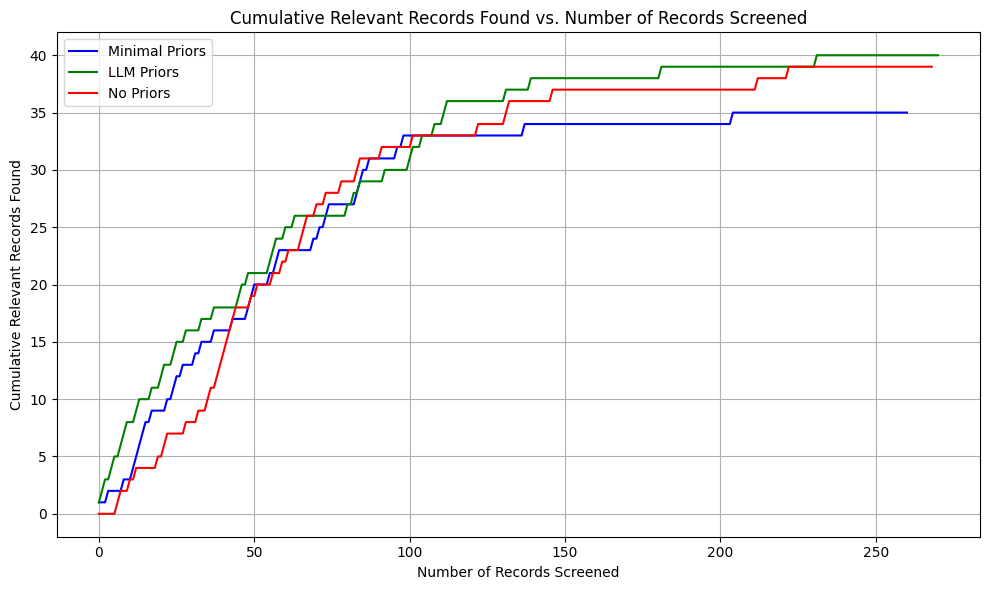

In [334]:
# generate a plot with cumulative sum of relevant records found over number of records screened for the three strategies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_cumsum['Minimal Priors'], label='Minimal Priors', color='blue')
plt.plot(df_cumsum['LLM Priors'], label='LLM Priors', color='green')
plt.plot(df_cumsum['No Priors'], label='No Priors', color='red')
plt.xlabel('Number of Records Screened')
plt.ylabel('Cumulative Relevant Records Found')
plt.title('Cumulative Relevant Records Found vs. Number of Records Screened')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [333]:
simulate_minimal._results

,record_id,label,classifier,querier,balancer,feature_extractor,training_set,time,note,tags,user_id
0,163,0,None,None,None,None,None,1.760702e+09,None,None,None
1,44,0,None,None,None,None,None,1.760702e+09,None,None,None
2,216,0,None,None,None,None,None,1.760702e+09,None,None,None
3,239,0,None,None,None,None,None,1.760702e+09,None,None,None
4,231,0,None,None,None,None,None,1.760702e+09,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
210,68,0,svm,max,balanced,tfidf,210,1.760702e+09,None,None,None
211,123,0,svm,max,balanced,tfidf,211,1.760702e+09,None,None,None
212,265,0,svm,max,balanced,tfidf,212,1.760702e+09,None,None,None
213,242,0,svm,max,balanced,tfidf,213,1.760702e+09,None,None,None
